# Replicating Lin et al. (2008): Study 2

In [1]:
# Import packaqes
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from decimal import *
%matplotlib inline

In [2]:
# Define Parameters
sigma = 3 #shear
lam = 0.1 #damping
A = 0.1 #kick amplitude
#T = 2 #time interval of kicks

In [3]:
# Build Map reduction of dynamics: Lin. et al equation 5
def H(theta):
    return np.sin(2*np.pi*theta)

def rand_T(mean_T):
    return np.random.exponential(mean_T)

def f_map(theta,y,lam, sigma, T, A): # for theta
    return (theta + T + (sigma/lam)*(y + A*H(theta))*(1 - np.exp(-lam*T))) % 1

def g_map(theta, y, lam, T, A): # for y
    return np.exp(-lam*T)*(y + A*H(theta))

In [4]:
# Compute Jacobian of map reduction
c2 = sigma/lam

def jac1(theta, T, A):
    c3 = 2*np.pi*A*np.cos(2*np.pi*theta)
    c1 = np.exp(-lam*T)
    
    # see: https://docs.python.org/3/library/decimal.html
    return np.array([[Decimal((1 + c2*c3*(1-c1))), Decimal((c2*(1-c1)))],
                     [Decimal((c1*c3)), Decimal(c1)]]) 

In [5]:
# Run test simulations

Ts = np.linspace(0.1,20,40)
sim_ly_s = []

for t in tqdm.tqdm(Ts):
    T = t # set time between kicks
    
    max_run = 1 # no. of replications
    max_iter = 1000 # no. of map iterations
    
    run_ly_s = []
    
    # Run with fixed parameter values
    for i in range(max_run):

        # random initial state
        theta_T = np.random.uniform(0,1)
        y_T = np.random.uniform(-0.1, 0.1)

        # generate unit tangent vector
        u = np.array([0,1]).T
        log_arg = u # initialize log argument for lyapunov exponent

        for i in range(max_iter):
            # Determine time of next kick
            T_kick = rand_T(T)
            A_kick = A*np.random.uniform(0.8,1.2)
            
            # Update jacobian product
            log_arg = jac1(theta_T, T_kick, A_kick).dot(log_arg)

            # Update system state: (theta,y)
            theta_T = f_map(theta_T, y_T, lam, sigma, T_kick, A_kick)
            y_T = g_map(theta_T, y_T, lam, T_kick, A_kick)

        # Store run values
        run_ly_s.append(float(Decimal(np.linalg.norm(log_arg)).ln()/max_iter))
        
    # Store max lyapunov exponents
    sim_ly_s.append(np.max(run_ly_s))

100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


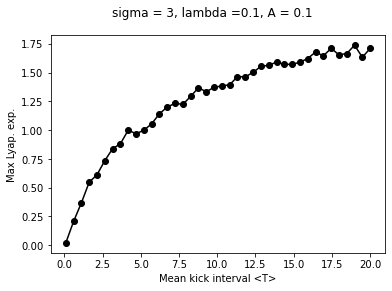

In [6]:
# Plot max lyapunov exponents
plt.plot(Ts, sim_ly_s, 'ko-')
plt.xlabel('Mean kick interval <T>')
plt.ylabel('Max Lyap. exp.')
plt.suptitle('sigma = {}, lambda ={}, A = {}'.format(sigma,lam,A))
plt.show()